In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import pydicom as dicom
import numpy as np
import tensorflow as tf
import cv2

from matplotlib import pyplot as plt
from pathlib import Path


# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n        \n"

In [2]:
DATADIR = Path("/kaggle/input/rsna-breast-cancer-detection")
ORIGINAL_DATASET = DATADIR / "train.csv"
NEW_DATASET = Path("/kaggle/working/postprocessed.csv")
TEST_SET = DATADIR / "test.csv"
SEED = 42

In [3]:
test_df = pd.read_csv(TEST_SET)
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [4]:
train_df = pd.read_csv(ORIGINAL_DATASET)
base_path = "/kaggle/input/rsna-breast-cancer-detection/train_images/"
all_paths = []
for k in range(len(train_df)):
    row = train_df.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + "/" + str(row.image_id) + ".dcm")
    
train_df["path"] = all_paths

In [5]:
# lets remove the views that do not belong to CC and MLO
train_df = train_df[train_df.view.apply(lambda x: x in ["CC", "MLO"])]
train_df.groupby(["view", "laterality"]).count()


site_id  patient_id  image_id    age  cancer  biopsy  \
view laterality                                                         
CC   L             13295       13295     13295  13286   13295   13295   
     R             13470       13470     13470  13462   13470   13470   
MLO  L             13958       13958     13958  13947   13958   13958   
     R             13945       13945     13945  13936   13945   13945   

                 invasive  BIRADS  implant  density  machine_id  \
view laterality                                                   
CC   L              13295    6375    13295     7067       13295   
     R              13470    6418    13470     7229       13470   
MLO  L              13958    6782    13958     7571       13958   
     R              13945    6685    13945     7570       13945   

                 difficult_negative_case   path  
view laterality                                  
CC   L                             13295  13295  
     R                             13470  13470  
MLO  L                             13958  13958  
     R                             13945  13945

In [6]:
# take all the positive cases
patients = []
patients += train_df[train_df.cancer == 1].patient_id.unique().tolist()
patients += train_df[train_df.difficult_negative_case].patient_id.unique().tolist()
patients = list(np.unique(patients))
remaining = train_df[train_df.patient_id.apply(lambda x: x not in patients)].patient_id.unique().tolist()
print(f"Number of selected patients: {len(patients)}")
print(f"Number of remaining patients: {len(remaining)}")
print(f"Total patients: {len(patients) + len(remaining)}")

Number of selected patients: 3569
Number of remaining patients: 8344
Total patients: 11913


In [7]:
class Processor():
    
    def __init__(
            self,
            path
    ):
        self.path = path
        
    def read_images(self, image_size=None,fix_monochrome = True):
        dc = dicom.dcmread(self.path)
        img = dc.pixel_array
        if fix_monochrome and dc.PhotometricInterpretation == "MONOCHROME1":
            img = np.amax(img) - img
            
        if image_size:
            img = cv2.resize(img,image_size)
            
        img = img - np.min(img)
        img = img / np.max(img)
        img = (img * 255).astype(np.uint8)

        return img
    
    def apply_clahe(self,img,cliplimit=2,tilegridsize=(8,8)):
        clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=tilegridsize)
        cl1 = clahe.apply(img)
        return cl1

    def apply_eh(self, img):
        img = cv2.equalizeHist(img)
        return img
    
    def crop_roi(self,img):
        
        if len(img.shape) > 2:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint8)
        else:
            gray = img.astype(np.uint8)

        ret, gray = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)
        gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (128, 128)))
        gray = cv2.bitwise_not(gray)

        contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour = max(contours, key = cv2.contourArea)

        x, y, w, h = cv2.boundingRect(contour)
        roi = img[y: y + h, x: x + w]
    
        
        return roi
        
        
        
        

        

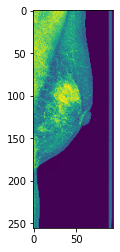

In [8]:
proc = Processor(train_df['path'][1])
img = proc.read_images(image_size=(256,256))
img = proc.apply_clahe(img)
img = proc.crop_roi(img)
plt.imshow(img)